In [1]:
import torch
print(torch.__version__)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1.1.0


In [2]:
import nltk
import os
import pickle
from collections import Counter
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
### build_vocab.py

In [4]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [5]:
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, cur_id in enumerate(ids):
        caption = str(coco.anns[cur_id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i + 1) % 10000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i + 1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [6]:
vocab = build_vocab(json="../datasets/COCO2014/annotations/captions_train2014.json", threshold=4)
vocab_path = "data/vocab.pkl"
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
[10000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[30000/414113] Tokenized the captions.
[40000/414113] Tokenized the captions.
[50000/414113] Tokenized the captions.
[60000/414113] Tokenized the captions.
[70000/414113] Tokenized the captions.
[80000/414113] Tokenized the captions.
[90000/414113] Tokenized the captions.
[100000/414113] Tokenized the captions.
[110000/414113] Tokenized the captions.
[120000/414113] Tokenized the captions.
[130000/414113] Tokenized the captions.
[140000/414113] Tokenized the captions.
[150000/414113] Tokenized the captions.
[160000/414113] Tokenized the captions.
[170000/414113] Tokenized the captions.
[180000/414113] Tokenized the captions.
[190000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[24000

In [7]:
### resize.py

In [8]:
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i + 1) % 1000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i + 1, num_images, output_dir))

In [9]:
image_dir = "../datasets/COCO2014/train2014"
output_dir = "data/resized2014"
image_size = 256
resize_images(image_dir, output_dir, [image_size, image_size])

[1000/82783] Resized the images and saved into 'data/resized2014'.
[2000/82783] Resized the images and saved into 'data/resized2014'.
[3000/82783] Resized the images and saved into 'data/resized2014'.
[4000/82783] Resized the images and saved into 'data/resized2014'.
[5000/82783] Resized the images and saved into 'data/resized2014'.
[6000/82783] Resized the images and saved into 'data/resized2014'.
[7000/82783] Resized the images and saved into 'data/resized2014'.
[8000/82783] Resized the images and saved into 'data/resized2014'.
[9000/82783] Resized the images and saved into 'data/resized2014'.
[10000/82783] Resized the images and saved into 'data/resized2014'.
[11000/82783] Resized the images and saved into 'data/resized2014'.
[12000/82783] Resized the images and saved into 'data/resized2014'.
[13000/82783] Resized the images and saved into 'data/resized2014'.
[14000/82783] Resized the images and saved into 'data/resized2014'.
[15000/82783] Resized the images and saved into 'data/res

In [5]:
### model.py

In [6]:
# Create model directory
model_path = "models"
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open("data/vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)

In [7]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

In [8]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [9]:
coco = CocoDataset(root="data/resized2014",
                   json="../datasets/COCO2014/annotations/captions_train2014.json",
                   vocab=vocab,
                   transform=transform)
    
# Data loader for COCO dataset
# This will return (images, captions, lengths) for each iteration.
# images: a tensor of shape (batch_size, 3, 224, 224).
# captions: a tensor of shape (batch_size, padded_length).
# lengths: a list indicating valid length for each caption. length is (batch_size).
data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super().__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [12]:
# Build the models
encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab), num_layers=1).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [13]:
# Train the models
total_step = len(data_loader)
# num_epochs = 5
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        log_step = 10
        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

        save_step = 1000
        # Save the model checkpoints
        if (i + 1) % save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                model_path, 'decoder-{}-{}.ckpt'.format(epoch + 1, i + 1)))
            torch.save(encoder.state_dict(), os.path.join(
                model_path, 'encoder-{}-{}.ckpt'.format(epoch + 1, i + 1)))

Epoch [0/2], Step [0/3236], Loss: 9.2139, Perplexity: 10036.0482
Epoch [0/2], Step [10/3236], Loss: 5.9581, Perplexity: 386.8778
Epoch [0/2], Step [20/3236], Loss: 5.3310, Perplexity: 206.6519
Epoch [0/2], Step [30/3236], Loss: 4.9624, Perplexity: 142.9424
Epoch [0/2], Step [40/3236], Loss: 4.6648, Perplexity: 106.1422
Epoch [0/2], Step [50/3236], Loss: 4.3584, Perplexity: 78.1359
Epoch [0/2], Step [60/3236], Loss: 4.2961, Perplexity: 73.4157
Epoch [0/2], Step [70/3236], Loss: 4.1311, Perplexity: 62.2462
Epoch [0/2], Step [80/3236], Loss: 4.1705, Perplexity: 64.7477
Epoch [0/2], Step [90/3236], Loss: 3.9564, Perplexity: 52.2693
Epoch [0/2], Step [100/3236], Loss: 3.9958, Perplexity: 54.3706
Epoch [0/2], Step [110/3236], Loss: 3.8542, Perplexity: 47.1930
Epoch [0/2], Step [120/3236], Loss: 3.6778, Perplexity: 39.5610
Epoch [0/2], Step [130/3236], Loss: 3.7694, Perplexity: 43.3561
Epoch [0/2], Step [140/3236], Loss: 3.7159, Perplexity: 41.0962
Epoch [0/2], Step [150/3236], Loss: 3.5619, 

Epoch [0/2], Step [1280/3236], Loss: 2.4884, Perplexity: 12.0419
Epoch [0/2], Step [1290/3236], Loss: 2.5155, Perplexity: 12.3730
Epoch [0/2], Step [1300/3236], Loss: 2.5845, Perplexity: 13.2564
Epoch [0/2], Step [1310/3236], Loss: 2.5163, Perplexity: 12.3824
Epoch [0/2], Step [1320/3236], Loss: 2.3747, Perplexity: 10.7473
Epoch [0/2], Step [1330/3236], Loss: 2.4602, Perplexity: 11.7067
Epoch [0/2], Step [1340/3236], Loss: 2.5848, Perplexity: 13.2612
Epoch [0/2], Step [1350/3236], Loss: 2.5964, Perplexity: 13.4154
Epoch [0/2], Step [1360/3236], Loss: 2.4709, Perplexity: 11.8326
Epoch [0/2], Step [1370/3236], Loss: 2.5777, Perplexity: 13.1672
Epoch [0/2], Step [1380/3236], Loss: 2.4796, Perplexity: 11.9362
Epoch [0/2], Step [1390/3236], Loss: 2.4952, Perplexity: 12.1240
Epoch [0/2], Step [1400/3236], Loss: 2.4831, Perplexity: 11.9782
Epoch [0/2], Step [1410/3236], Loss: 2.4347, Perplexity: 11.4129
Epoch [0/2], Step [1420/3236], Loss: 2.7597, Perplexity: 15.7945
Epoch [0/2], Step [1430/3

Epoch [0/2], Step [2550/3236], Loss: 2.2623, Perplexity: 9.6055
Epoch [0/2], Step [2560/3236], Loss: 2.4894, Perplexity: 12.0542
Epoch [0/2], Step [2570/3236], Loss: 2.3718, Perplexity: 10.7172
Epoch [0/2], Step [2580/3236], Loss: 2.2698, Perplexity: 9.6771
Epoch [0/2], Step [2590/3236], Loss: 2.2021, Perplexity: 9.0439
Epoch [0/2], Step [2600/3236], Loss: 2.3360, Perplexity: 10.3399
Epoch [0/2], Step [2610/3236], Loss: 2.3215, Perplexity: 10.1910
Epoch [0/2], Step [2620/3236], Loss: 2.1552, Perplexity: 8.6292
Epoch [0/2], Step [2630/3236], Loss: 2.2835, Perplexity: 9.8108
Epoch [0/2], Step [2640/3236], Loss: 2.3430, Perplexity: 10.4128
Epoch [0/2], Step [2650/3236], Loss: 2.4189, Perplexity: 11.2338
Epoch [0/2], Step [2660/3236], Loss: 2.2085, Perplexity: 9.1019
Epoch [0/2], Step [2670/3236], Loss: 2.2914, Perplexity: 9.8883
Epoch [0/2], Step [2680/3236], Loss: 2.2682, Perplexity: 9.6621
Epoch [0/2], Step [2690/3236], Loss: 2.3010, Perplexity: 9.9838
Epoch [0/2], Step [2700/3236], Los

Epoch [1/2], Step [600/3236], Loss: 2.1772, Perplexity: 8.8212
Epoch [1/2], Step [610/3236], Loss: 2.0951, Perplexity: 8.1259
Epoch [1/2], Step [620/3236], Loss: 2.2344, Perplexity: 9.3405
Epoch [1/2], Step [630/3236], Loss: 2.1003, Perplexity: 8.1690
Epoch [1/2], Step [640/3236], Loss: 2.1349, Perplexity: 8.4564
Epoch [1/2], Step [650/3236], Loss: 2.2826, Perplexity: 9.8023
Epoch [1/2], Step [660/3236], Loss: 2.2992, Perplexity: 9.9658
Epoch [1/2], Step [670/3236], Loss: 2.0414, Perplexity: 7.7013
Epoch [1/2], Step [680/3236], Loss: 2.1077, Perplexity: 8.2297
Epoch [1/2], Step [690/3236], Loss: 1.9894, Perplexity: 7.3112
Epoch [1/2], Step [700/3236], Loss: 2.1991, Perplexity: 9.0171
Epoch [1/2], Step [710/3236], Loss: 2.1657, Perplexity: 8.7208
Epoch [1/2], Step [720/3236], Loss: 2.2047, Perplexity: 9.0677
Epoch [1/2], Step [730/3236], Loss: 2.1203, Perplexity: 8.3334
Epoch [1/2], Step [740/3236], Loss: 2.0558, Perplexity: 7.8127
Epoch [1/2], Step [750/3236], Loss: 2.1079, Perplexity:

Epoch [1/2], Step [1890/3236], Loss: 2.2595, Perplexity: 9.5783
Epoch [1/2], Step [1900/3236], Loss: 2.1625, Perplexity: 8.6924
Epoch [1/2], Step [1910/3236], Loss: 2.0160, Perplexity: 7.5082
Epoch [1/2], Step [1920/3236], Loss: 2.1701, Perplexity: 8.7594
Epoch [1/2], Step [1930/3236], Loss: 2.1723, Perplexity: 8.7782
Epoch [1/2], Step [1940/3236], Loss: 2.1112, Perplexity: 8.2578
Epoch [1/2], Step [1950/3236], Loss: 2.1711, Perplexity: 8.7679
Epoch [1/2], Step [1960/3236], Loss: 2.1210, Perplexity: 8.3393
Epoch [1/2], Step [1970/3236], Loss: 2.1204, Perplexity: 8.3342
Epoch [1/2], Step [1980/3236], Loss: 2.0446, Perplexity: 7.7257
Epoch [1/2], Step [1990/3236], Loss: 2.0731, Perplexity: 7.9492
Epoch [1/2], Step [2000/3236], Loss: 2.1121, Perplexity: 8.2657
Epoch [1/2], Step [2010/3236], Loss: 2.1576, Perplexity: 8.6502
Epoch [1/2], Step [2020/3236], Loss: 2.2140, Perplexity: 9.1524
Epoch [1/2], Step [2030/3236], Loss: 1.9853, Perplexity: 7.2810
Epoch [1/2], Step [2040/3236], Loss: 2.0

Epoch [1/2], Step [3180/3236], Loss: 2.1242, Perplexity: 8.3660
Epoch [1/2], Step [3190/3236], Loss: 2.1003, Perplexity: 8.1689
Epoch [1/2], Step [3200/3236], Loss: 2.1181, Perplexity: 8.3150
Epoch [1/2], Step [3210/3236], Loss: 2.1080, Perplexity: 8.2318
Epoch [1/2], Step [3220/3236], Loss: 2.1407, Perplexity: 8.5050
Epoch [1/2], Step [3230/3236], Loss: 2.1790, Perplexity: 8.8373


In [7]:
### sample.py

In [8]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
original caption: A very clean and well decorated empty bathroom
generated caption: <start> a bathroom with a sink and a mirror on the wall <end>


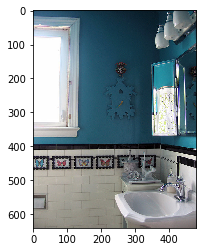

In [9]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
# Load vocabulary wrapper
with open("data/vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size=256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab), num_layers=1)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder_path = "models/encoder-2-3000.ckpt"
decoder_path = "models/decoder-2-3000.ckpt"
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
coco = COCO("../datasets/COCO2014/annotations/captions_train2014.json")
ids = list(coco.anns.keys())
caption = coco.anns[ids[0]]['caption']
img_id = coco.anns[ids[0]]['image_id']
path = coco.loadImgs(img_id)[0]['file_name']
input_image = os.path.join("../datasets/COCO2014/train2014/", path)
image = load_image(input_image, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print("original caption:", caption)
print("generated caption:", sentence)
image = Image.open(input_image)
plt.imshow(np.asarray(image))